In [0]:
%pip install bokeh

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
clinicDate = 2021
fileName = 'clinicaltrial'
clinicDf = spark.read.options(header=True, delimiter='|').csv("/FileStore/tables/{}_{}.csv".format(fileName, clinicDate))
meshDf = spark.read.options(header=True, delimiter=',').csv('/FileStore/tables/mesh.csv')
pharmaDf = spark.read.options(header=True, delimiter=',').csv('/FileStore/tables/pharma.csv')

In [0]:
# task 1

clinicDf.distinct().count()

Out[2]: 387261

In [0]:
# task 2

clinicDf.groupby("Type").count().orderBy("count", ascending=False).show(10)

+--------------------+------+
|                Type| count|
+--------------------+------+
|      Interventional|301472|
|       Observational| 77540|
|Observational [Pa...|  8180|
|     Expanded Access|    69|
+--------------------+------+



In [0]:
# task 3
from pyspark.sql.functions import explode, split, col

conddf = clinicDf.withColumn('condition', split(clinicDf.Conditions, ',')).withColumn('condition', explode(col('condition')))
conddf.groupby("condition").count().orderBy("count", ascending=False).show(5)

+-----------------+-----+
|        condition|count|
+-----------------+-----+
|        Carcinoma|13389|
|Diabetes Mellitus|11080|
|        Neoplasms| 9371|
| Breast Neoplasms| 8640|
|         Syndrome| 8032|
+-----------------+-----+
only showing top 5 rows



In [0]:
# task 4

meshtreedf = meshDf.withColumn('newtree', split(meshDf['tree'], '[\.]')[0])
conddf=clinicDf.withColumn('condition', split(clinicDf.Conditions, ',')).withColumn('condition', explode(col('condition')))

conddf.join(meshtreedf, conddf.condition==meshtreedf.term).groupby("newtree").count().orderBy("count", ascending=False).show(5)

+-------+------+
|newtree| count|
+-------+------+
|    C04|143994|
|    C23|136079|
|    C01|106674|
|    C14| 94523|
|    C10| 92310|
+-------+------+
only showing top 5 rows



In [0]:
# task 5

exclusiveParentCompany = set([i.Parent_Company for i in pharmaDf.collect()])

clinicDf.where(~clinicDf.Sponsor.isin(exclusiveParentCompany)).groupby("Sponsor").count().orderBy("count", ascending=False).show(10)

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3218|
|M.D. Anderson Can...| 2414|
|Assistance Publiq...| 2369|
|         Mayo Clinic| 2300|
|Merck Sharp & Doh...| 2243|
|   Assiut University| 2154|
|Novartis Pharmace...| 2088|
|Massachusetts Gen...| 1971|
|    Cairo University| 1928|
|   Hoffmann-La Roche| 1828|
+--------------------+-----+
only showing top 10 rows



In [0]:
# task 6

comdf = clinicDf.withColumn('compDate', split(clinicDf['Completion'], ' ')).where(col('compDate')[1]==str(clinicDate)).filter(clinicDf['Status']=='Completed')
comdfOutcome = comdf.groupby(col('compDate')[0]).count().orderBy("count").withColumnRenamed('compDate[0]', 'compMonth').collect()

In [0]:
comMonthOrdering = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
comMonthOrderingOutCome = []
for c in comMonthOrdering:
    for row in comdfOutcome:
        if c == row[0]:
            comMonthOrderingOutCome.append((c,row[1]))
            
comMonthOrderingOutCome

Out[20]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

In [0]:
from bokeh.io import output_file, show
from bokeh.embed import file_html
from bokeh.plotting import figure
from bokeh.resources import CDN

months = [i[0] for i in comMonthOrderingOutCome]
counts = [i[1] for i in comMonthOrderingOutCome]

plt = figure(x_range=months, height=300, title="Completions per Month", plot_height=400)

plt.vbar(x=months, top=counts, width=0.45)
plt.y_range.start = 0

html = file_html(plt, CDN, "bar")
displayHTML(html)

<!DOCTYPE html>
 
 
 
 
 
 bar

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


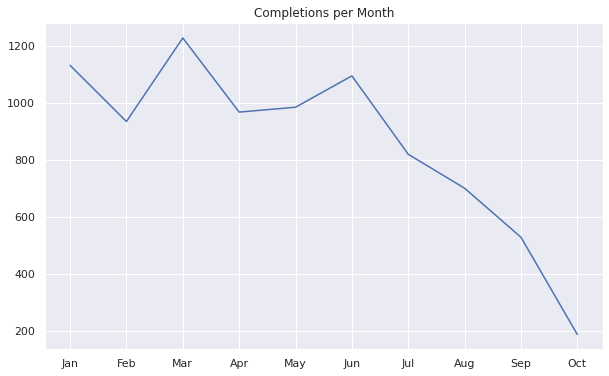

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")

x = [i[0] for i in comMonthOrderingOutCome]
y = [i[1] for i in comMonthOrderingOutCome]

sns.set(rc = {'figure.figsize':(10,6)})
s = sns.lineplot(x, y, err_style='bars')
s.set_title("Completions per Month")
plt.show()